# 1. 사전 세팅

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/7_pet_adoption_duration_analysis"

# 2. 문제 정의

---

    애완 동물은 어느 순간부터 우리의 가족과도 같은 존재가 되었지만, 이 순간에도 많은 사람들이 애완동물을 유기하기도 한다.
    그래서 분양된 동물들의 데이터를 분석해 어떤 동물들이 분양이 잘 되는지 분석해보고자 한다.
    예로, 통제 가능한 변수(백신, 중성화, 사진 수 등)의 영향도 분석으로 어떤 분양 프로필을 작성하는 것이 분양에 도움이 되는지도 알아보고자 한다.

# 3. 데이터 간단 확인

## 3.1. 데이터 명세

---

| Column | Description |
| :------------------ | :------------------------- |
| `Type`         | 애완동물 종류 (1: 개, 2: 고양이) |
| `Age`            | 나이 |
| `Breed1`           | 견종, 묘종  |
| `Color1`         | 첫번째 색깔                  |
| `Color2`              | 두번째 색깔                |
| `MaturitySize`        | 크기(1: 소형, 2: 중형, 3: 대형, 4: 초대형, 0: 정의 X)    |
| `FurLength`       | 털 길이(1: 짧은, 2: 중간, 3: 긴, 0: 정의 X) |
| `Vaccinated`         | 백신 접종 여부           |
| `Sterilized`    | 중성화 여부               |
| `Health`          | 건강 상태(1: 건강함, 2: 약간 아픔, 3: 많이 아픔, 0: 정의 X)                   |
| `Fee` | 분양 비용         |
| `Description` | 애완동물에 대한 설명         |
| `PhotoAmt` | 업로드된 애완동물의 전체 사진 수     |
| `AdoptionSpeed` | 분양된 속도. 작을수록 빨리 분양된 것, 4: 분양되지 않음       |

## 3.2. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- Object 자료형의 데이터를 Categorical 자료형으로 변환<br>- SMD(Standardized Mean Difference)를 통한 데이터 표준화<br><br><b>데이터 분할</b><br><br>- 검증을 위해 학습 데이터 80%, 검증 데이터 20%로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 11537 / column: 15 / table: 1<br><br> <b>To be</b><br><br>- row: 11528(-9) / column: 47(+32) / table: 1  |

## 3.3. 데이터 살펴보기

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/petfinder-mini.csv')
df.head()

In [ ]:
df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64
 14  AdoptionSpeed  11537 non-null  int64
dtypes: int64(4), object(11)
memory usage: 1.3+ MB
```



## 3.4. Category Column으로 사용할 수 있는 변수 탐색

In [ ]:
df.select_dtypes(include=np.number).columns.tolist()

In [ ]:
for col in df.columns.tolist():
    print(f'{col}: {df[col].astype('category').cat.codes.nunique()}')

# 4. 문제 해결 프로세스 정의

---

▸ 문제

    애완동물의 수요가 많아지는만큼 유기되고 있는 애완동물의 수도 점점 많아지고 있다.
    유기된 동물들은 동물보호단체에서 구조해 새로운 가족을 찾는 이들에게 입양해주고 있다.

    1. As-Is
    구조된 동물의 나이, 종, 색깔 등의 다양한 정보와 사진을 이용해 프로필을 작성하고 입양 희망자가 있는 경우,
    일련의 절차를 거쳐 입양하는 과정을 거친다.

    2. To-Be
    어떠한 특성을 가진 동물들이 입양이 잘 되는지에 대해 분석하고,
    통제할 수 없는 변수와 통제 가능한 변수를 분류해 원활한 입양이 되기 위해 어떤 프로필을 적는 것이 좋은지도 알아낸다.

    3. Goal
    특성에 따른 입양 가능 예측 모델, 통제 가능한 변수에 대한 최적값 탐색
    
▸ 기대 효과

    애완동물의 색깔, 종, 나이와 같이 통제가 불가능한 변수의 경우에는 결과에 영향을 미칠 수 있도록 변경이 불가능하다.
    그러나, 프로필에 포함된 사진의 수와 같이 통제 가능 변수 분석으로 프로필 내 사진 개수의 최적값을 찾을 수 있다.

▸ 해결 방안

    object 자료형의 경우에는 보통 학습 알고리즘에 대부분 사용되기 어렵기에 수치형으로 변형
    Linear Model 및 tensorflow의 Neural Network 구조를 통한 모델링

▸ 성과 측정

    애완동물 입양 가능 확률

▸ 현업 적용

    Binary Classification 문제에서의 다양한 알고리즘 적용

# 5. 데이터 확인

## 5.1. 필요한 라이브러리 Import

In [ ]:
from datetime import datetime
from math import exp
from collections import defaultdict

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

# Plot Data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

from IPython.display import HTML, Image, display, Markdown as md

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 5.2. 데이터 정보 확인

In [ ]:
df = pd.read_csv('Data/petfinder-mini.csv')

In [ ]:
df.info()



```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64
 14  AdoptionSpeed  11537 non-null  int64
dtypes: int64(4), object(11)
memory usage: 1.3+ MB
```



    직장 서버에서 작업을 하는 경우가 대다수.
    특히, 가상 환경(Jupyter Hub 등)을 제공해주는 곳이 많은데, Docker로 할당받아 사용하는 경우가 많다.

    그러다 보니 데이터 사이즈를 보고 환경을 돌려야한다.
    큰 데이터로 작업하다보면, 커널이 죽는 경우가 자주 생기게 된다.

    지금은 메모리 환경에서 작업하다보니, 커널이 죽게 되면 작업 진행 상황이 무너질 수도 있다.

In [ ]:
df.shape



```
(11537, 15)
```



In [ ]:
df.dtypes

In [ ]:
df.select_dtypes(include=np.number).columns.tolist()



```
['Age', 'Fee', 'PhotoAmt', 'AdoptionSpeed']
```



In [ ]:
df.hist(figsize=(21, 9))
plt.show()

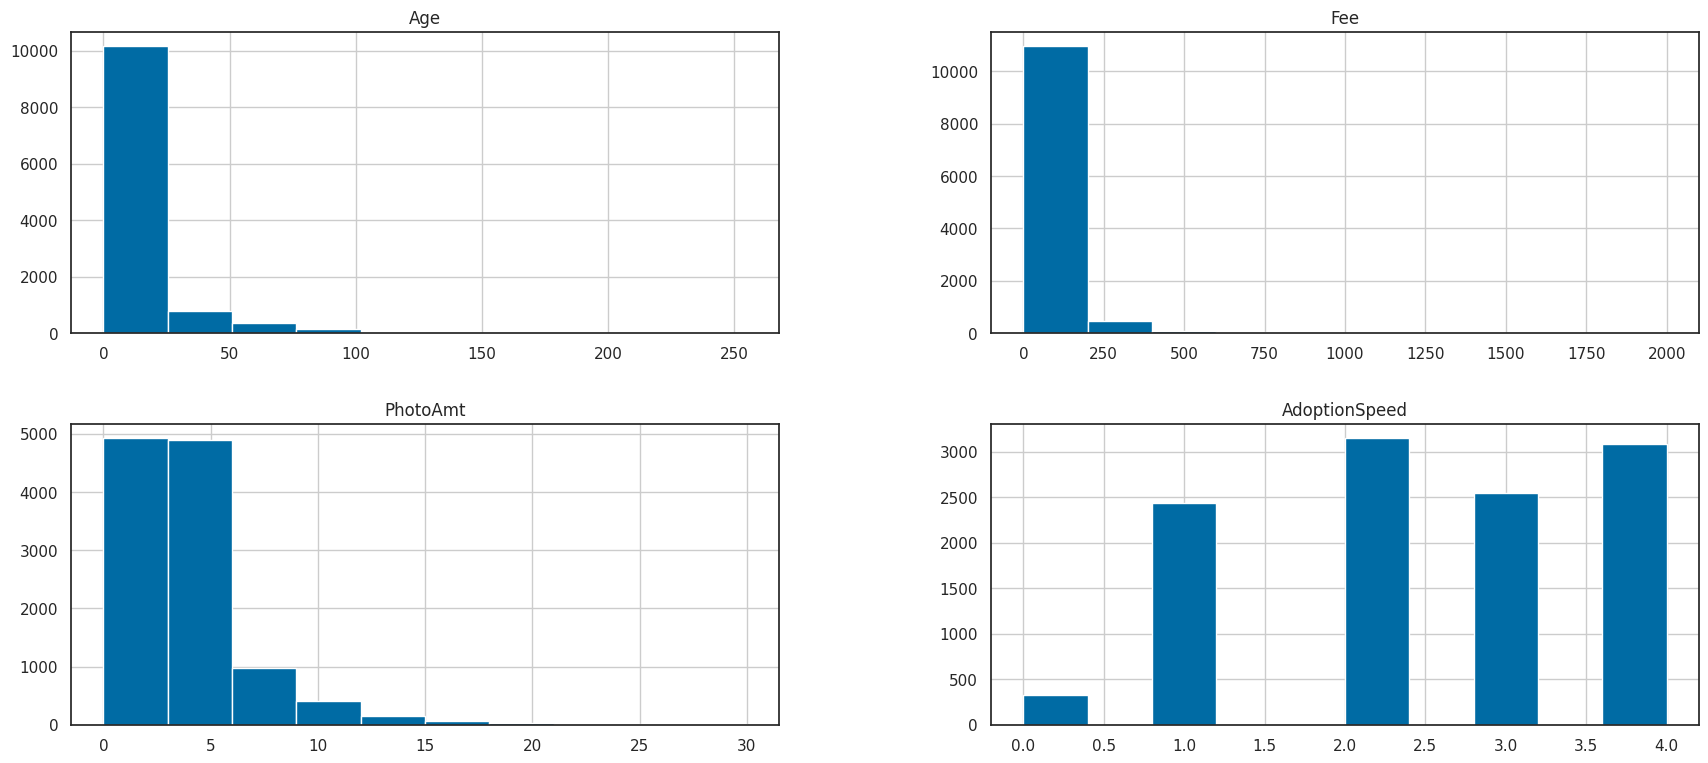

    환산이 되지 않은 나이가 있나?

In [ ]:
df['Age'].hist(figsize=(6, 4), bins=100)
plt.show()

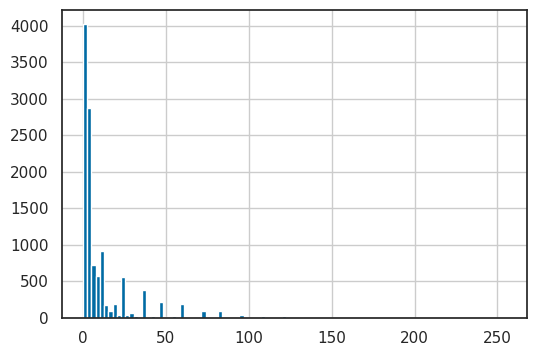

In [ ]:
df.describe().T.round(2)

In [ ]:
df.isna().sum()

# 6. Feature Engineering

## 6.1. 파생 변수 생성

In [ ]:
print(df['Description'].isna().sum())



```
9
```



In [ ]:
# 파생 변수를 만들기 위해 설명란이 결측인 데이터 행은 날리기
df = df.dropna(subset=['Description'])

# Binary 문제로 변형하기 위해, AdoptionSpeed가 4면, 입양 안 된 것, 그 외에는 된 것으로 변경
df['Adopted'] = np.where(df['AdoptionSpeed'] == 4, 0, 1)

# 설명으로도 무언가를 할 수 있을 듯하여 일단 파생 변수들 만들어보기
df['DescriptionLength'] = df['Description'].str.len()
df['WordCount'] = df['Description'].str.split().apply(len)
df['AvgWordLength'] = df['DescriptionLength'] / df['WordCount']

df = df.drop(columns=['AdoptionSpeed', 'Description'])
df.shape



```
(11528, 17)
```



In [ ]:
features = df.copy()
labels = features.pop('Adopted')

features.columns.tolist()



```
['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2',
 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee',
 'Description', 'PhotoAmt', 'DescriptionLength', 'WordCount', 'AvgWordLength']
```



In [ ]:
df.head()

## 6.2. Data Transformation

In [ ]:
features['IsCat'] = np.where(features['Type'] == 'Dog', 0, 1)

In [ ]:
features['IsFemale'] = np.where(features['Gender'] == 'Male', 0, 1)

In [ ]:
features['Vaccinated'].value_counts()

In [ ]:
# join에 on 옵션을 주지 않으면 인덱스 기준으로 Join하게 된다.
features = features.join(pd.get_dummies(features['Vaccinated'], prefix='Vaccinated', dtype=int))

In [ ]:
features['Sterilized'].value_counts()

In [ ]:
features = features.join(pd.get_dummies(features['Sterilized'], prefix='Sterilized', dtype=int))

In [ ]:
features = features.join(pd.get_dummies(features['Health'], prefix='Health', dtype=int))

In [ ]:
features['MaturitySize'].unique()



```
array(['Small', 'Medium', 'Large'], dtype=object)
```



In [ ]:
maturity_size_type = CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True)

In [ ]:
features['MaturitySize'] = features['MaturitySize'].astype(maturity_size_type)

In [ ]:
features['MaturitySize'].dtypes



```
CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True, categories_dtype=object)
```



In [ ]:
features = features.join(pd.get_dummies(features['MaturitySize'], prefix='MaturitySize', dtype=int))

In [ ]:
fur_length_type = CategoricalDtype(categories=['Short', 'Medium', 'Long'], ordered=True)
features['FurLength'] = features['FurLength'].astype(fur_length_type)
features = features.join(pd.get_dummies(features['FurLength'], prefix='FurLength', dtype=int))

In [ ]:
features['Color1'].unique()



```
array(['Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'], dtype=object)
```



In [ ]:
features = features.join(pd.get_dummies(features['Color1'], prefix='Color1', dtype=int))
features = features.join(pd.get_dummies(features['Color2'], prefix='Color2', dtype=int))

### 6.2.1. Age는 어떻게 처리하나...

In [ ]:
len(features['Age'].unique())



```
105
```



In [ ]:
# 5분위수로 나누어 처리하자 !
ptile_labels = ['ptile1', 'ptile2', 'ptile3', 'ptile4', 'ptile5']
features = features.join(pd.get_dummies(pd.qcut(features['Age'], q=[0, .2, .4, .6, .8, 1], labels=ptile_labels), prefix='Age', dtype=int))
features.head()

## 6.2.2. Breed(종) 변수 처리

In [ ]:
features['Breed1'].value_counts()[:20]

In [ ]:
keep_breeds = ['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair',
               'Tabby', 'Domestic Long Hair', 'Siamese', 'Shih Tzu',
               'Persian', 'Labrador Retriever', 'Poodle', 'Terrier', 'Golden Retriever']

dd = defaultdict(lambda: 'Other')

for _, breed in enumerate(keep_breeds):
    dd[breed] = breed

In [ ]:
features = features.join(pd.get_dummies(features['Breed1'].map(dd), prefix='Breed1', dtype=int))

In [ ]:
categorical_predictors = ['Type', 'Gender', 'Age', 'Color1', 'Color2', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

# 7. Data Readiness Check

## 7.1. Data Preprocessing

In [ ]:
print(len(list(features.columns)))



```
65
```



In [ ]:
list(features.columns)

In [ ]:
predictors = [
    # 'Type',
    # 'Age',
    # 'Breed1',
    # 'Gender',
    # 'Color1',
    # 'Color2',
    # 'MaturitySize',
    # 'FurLength',
    # 'Vaccinated',
    # 'Sterilized',
    # 'Health',
    # 'Fee',
    'PhotoAmt',
    'DescriptionLength',
    'WordCount',
    'AvgWordLength',
    'IsCat',
    'IsFemale',
    # 'Vaccinated_No',
    'Vaccinated_Not Sure',
    'Vaccinated_Yes',
    # 'Sterilized_No',
    'Sterilized_Not Sure',
    'Sterilized_Yes',
    'Health_Healthy',
    'Health_Minor Injury',
    'Health_Serious Injury',
    'MaturitySize_Small',
    'MaturitySize_Medium',
    'MaturitySize_Large',
    'FurLength_Short',
    'FurLength_Medium',
    'FurLength_Long',
    # 'Color1_Black',
    'Color1_Brown',
    'Color1_Cream',
    'Color1_Golden',
    'Color1_Gray',
    'Color1_White',
    'Color1_Yellow',
    'Color2_Brown',
    'Color2_Cream',
    'Color2_Golden',
    'Color2_Gray',
    # 'Color2_No Color',
    'Color2_White',
    'Color2_Yellow',
    'Age_ptile1',
    'Age_ptile2',
    'Age_ptile3',
    'Age_ptile4',
    # 'Age_ptile5',
    'Breed1_Domestic Long Hair',
    'Breed1_Domestic Medium Hair',
    'Breed1_Domestic Short Hair',
    'Breed1_Golden Retriever',
    'Breed1_Labrador Retriever',
    'Breed1_Mixed Breed',
    # 'Breed1_Other',
    'Breed1_Persian',
    'Breed1_Poodle',
    'Breed1_Shih Tzu',
    'Breed1_Siamese',
    'Breed1_Tabby',
    'Breed1_Terrier']

features = features[predictors].copy()

# SMD(표준화된 평균 차이)로 표준화
# 정규 분포에 가깝게 데이터를 표준화
features[predictors] = (features[predictors] - features[predictors].mean()) / features[predictors].std()

In [ ]:
features.head()

In [ ]:
# 데이터가 어떻게 변하는지 육안으로 계속 확인하는 것이 좋음
features.describe().T.round(2)

In [ ]:
features.hist(figsize=(21, 24))
plt.show()

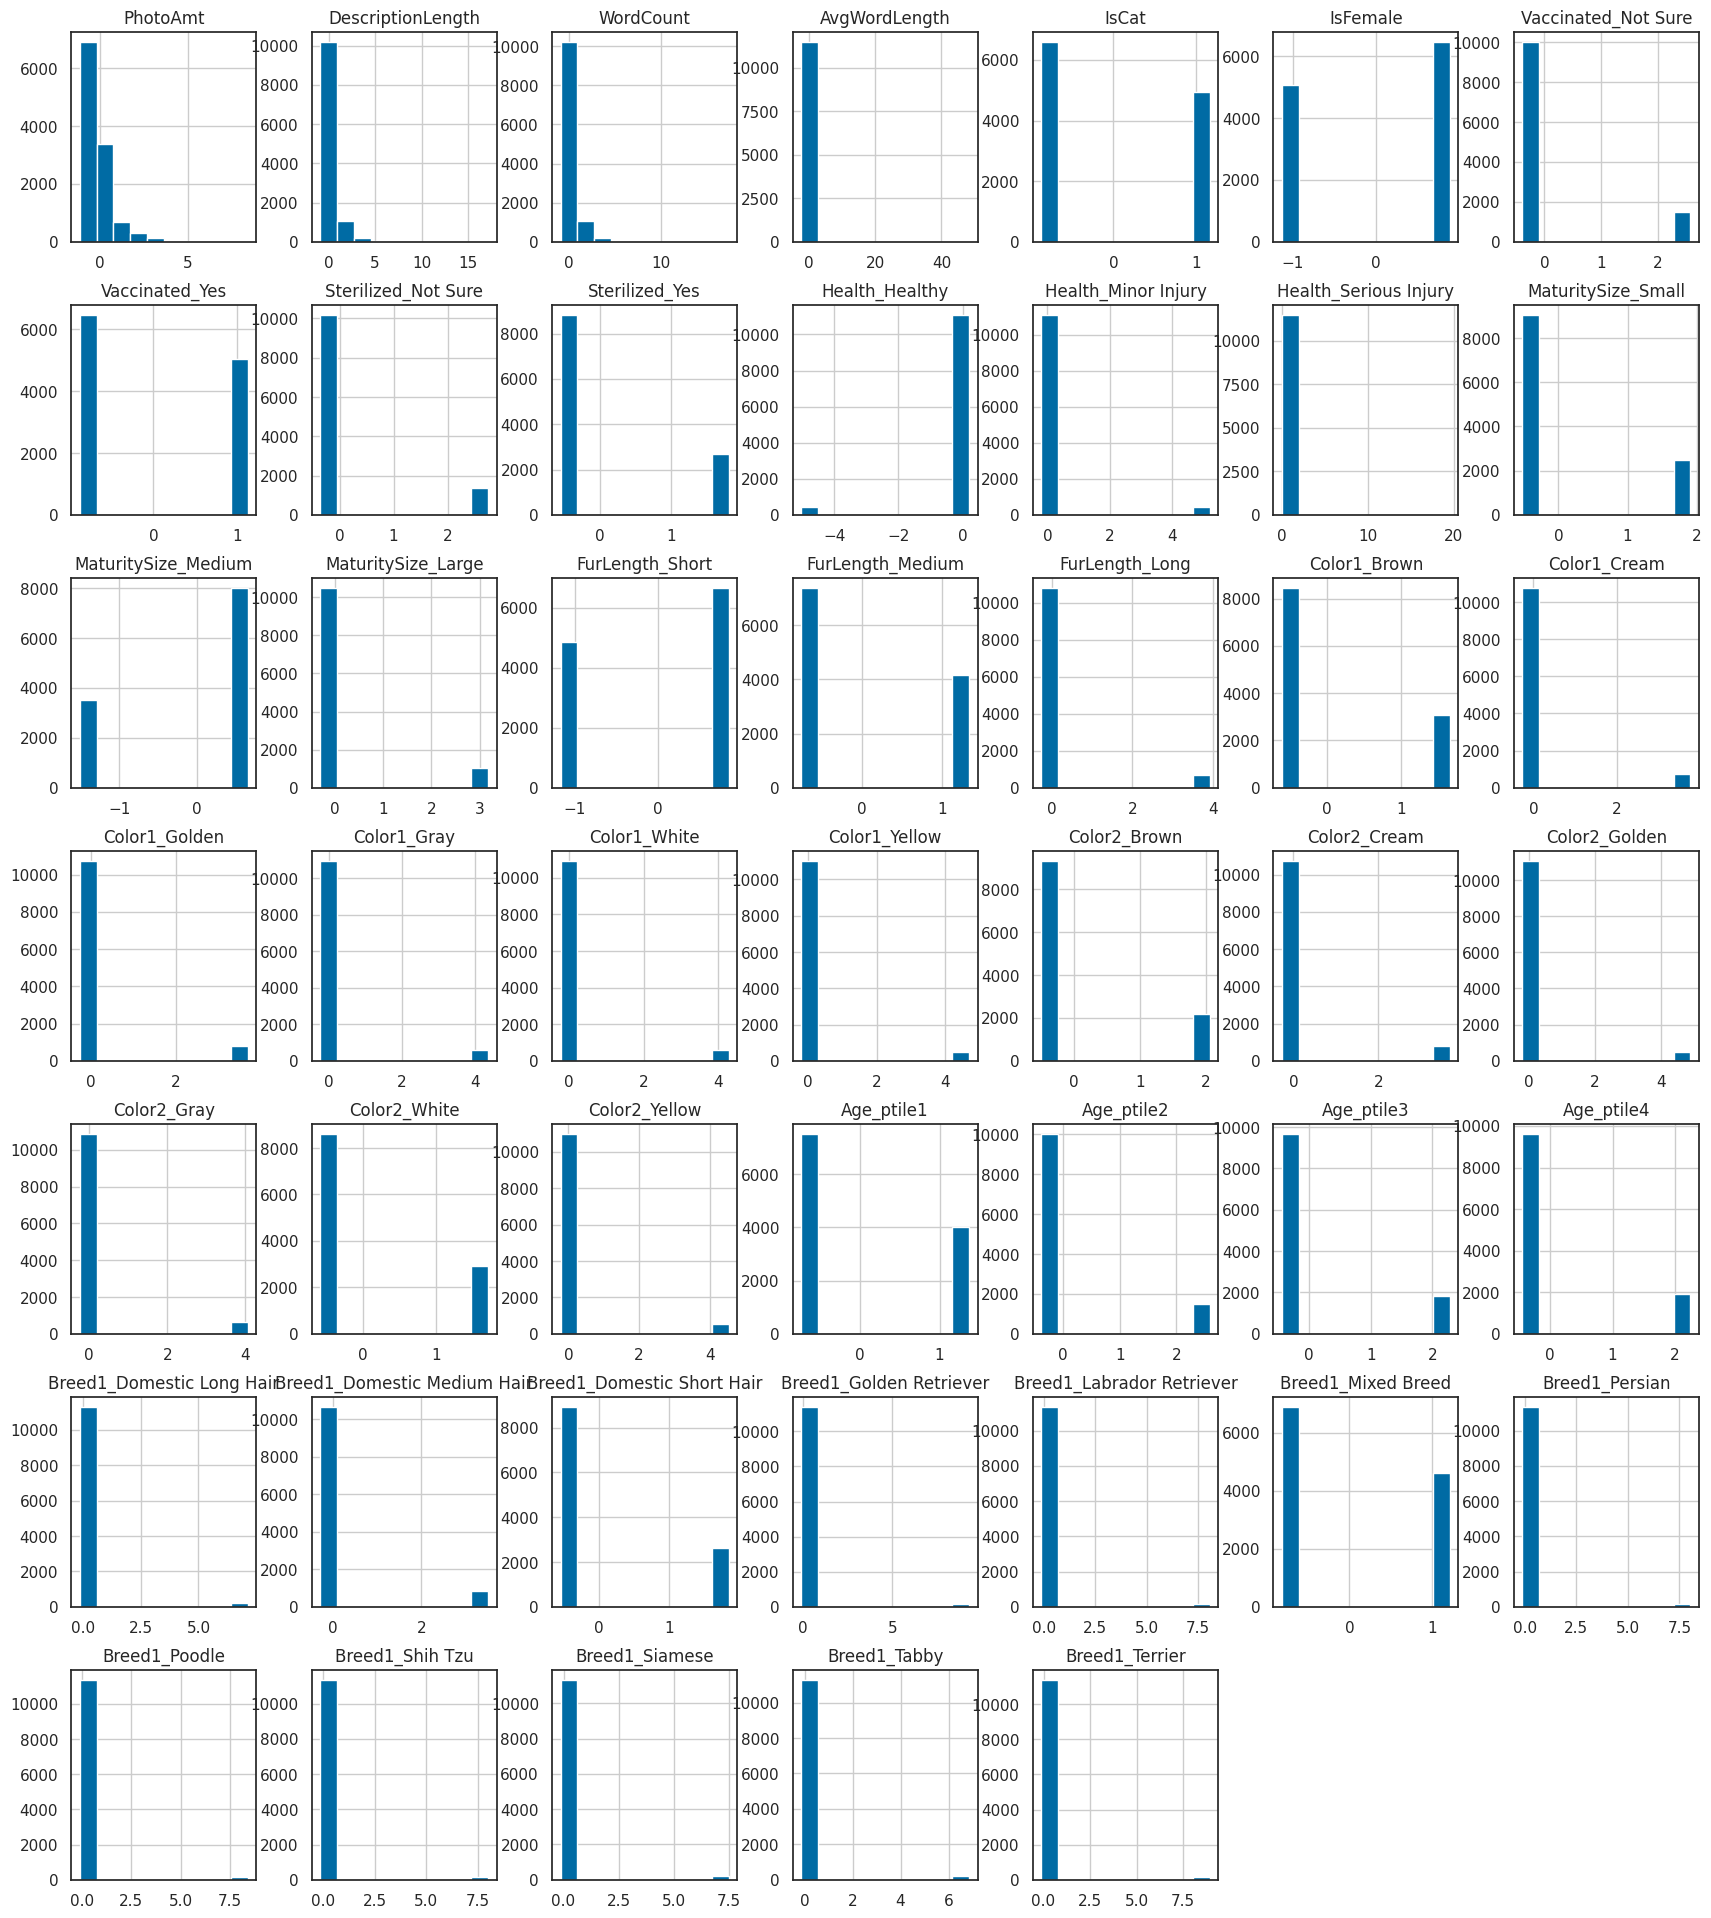

## 7.2. 설명 변수 관련 EDA

In [ ]:
desc_features = ['DescriptionLength', 'WordCount', 'AvgWordLength', 'PhotoAmt']
corr_matrix = features[desc_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

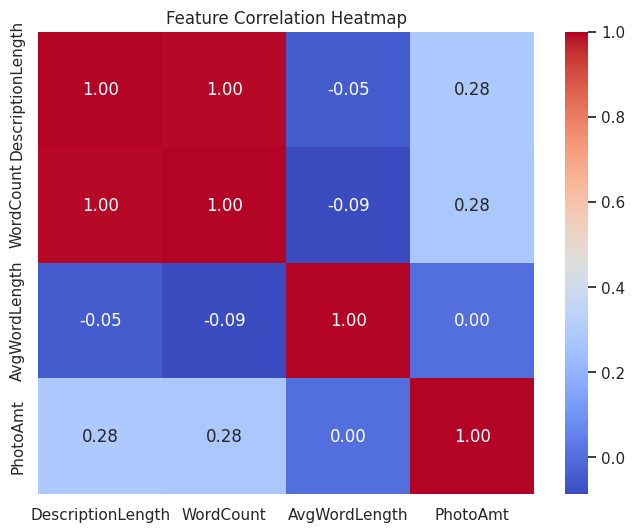

In [ ]:
plot_features = ['DescriptionLength', 'AvgWordLength']
plot_df = features.copy()
plot_df['Adopted'] = labels

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, feature in enumerate(plot_features):
    sns.boxplot(ax=axes[i], x='Adopted', y=feature, data=plot_df)
    axes[i].set_title(f'Adoption Status by {feature}')

plt.tight_layout()
plt.show()

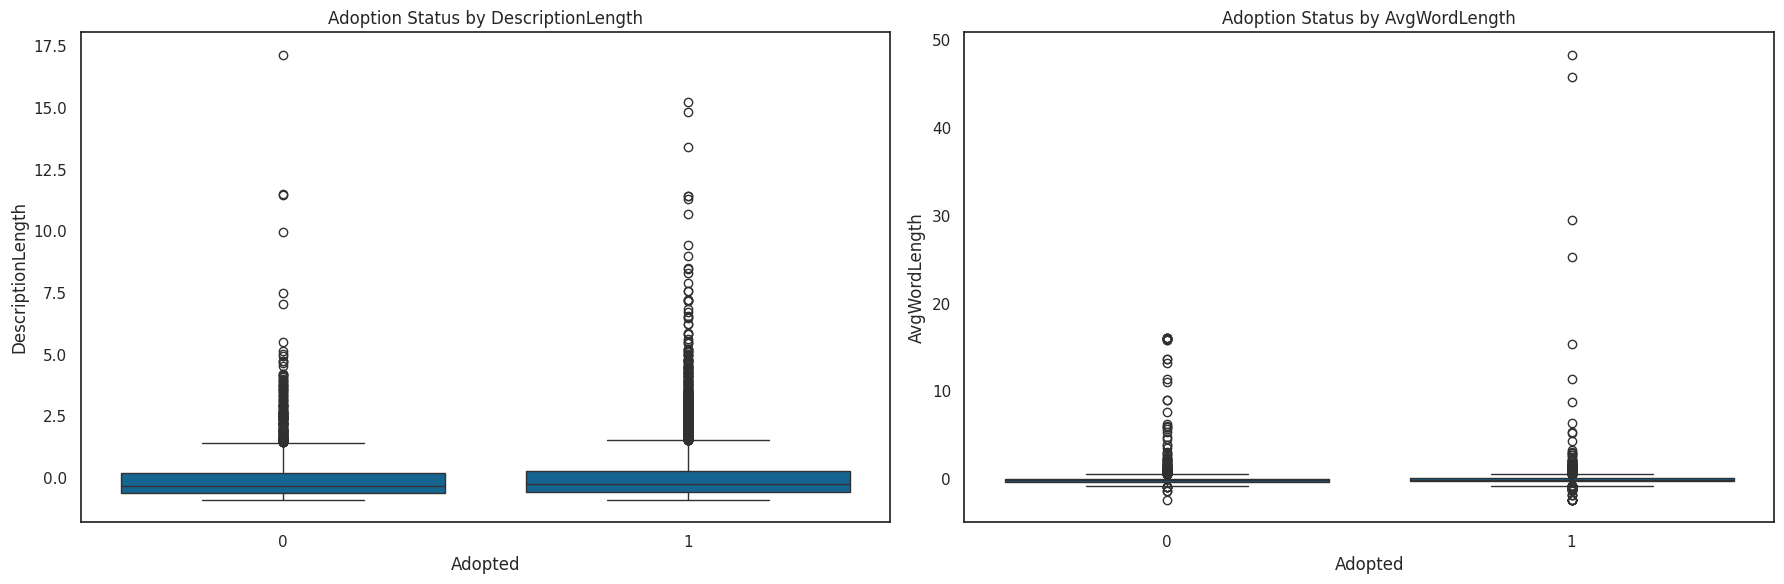

In [ ]:
plot_df['WordCount_bin'] = pd.qcut(plot_df['WordCount'], q=5, duplicates='drop')

plt.figure(figsize=(10, 6))
sns.barplot(x='WordCount_bin', y='Adopted', data=plot_df, ci=None)
plt.title('Adoption Rate by Word Count Bins')
plt.ylabel('Mean Adoption Rate')
plt.xlabel('Word Count (Quantile Bins)')
plt.show()

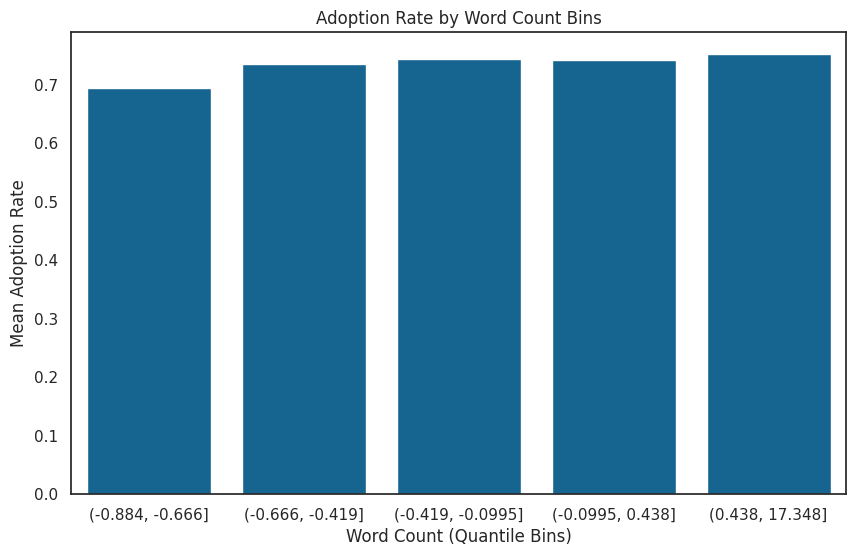

## 7.3. 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1234)

In [ ]:
X_train.shape, X_test.shape



```
((9222, 47), (2306, 47))
```



In [ ]:
g = sns.displot(X_train['PhotoAmt'], height=6, aspect=10/6)
g.set_axis_labels('Total uploaded photos for this pet (standardized)', '')
g.set_titles('')
plt.show()

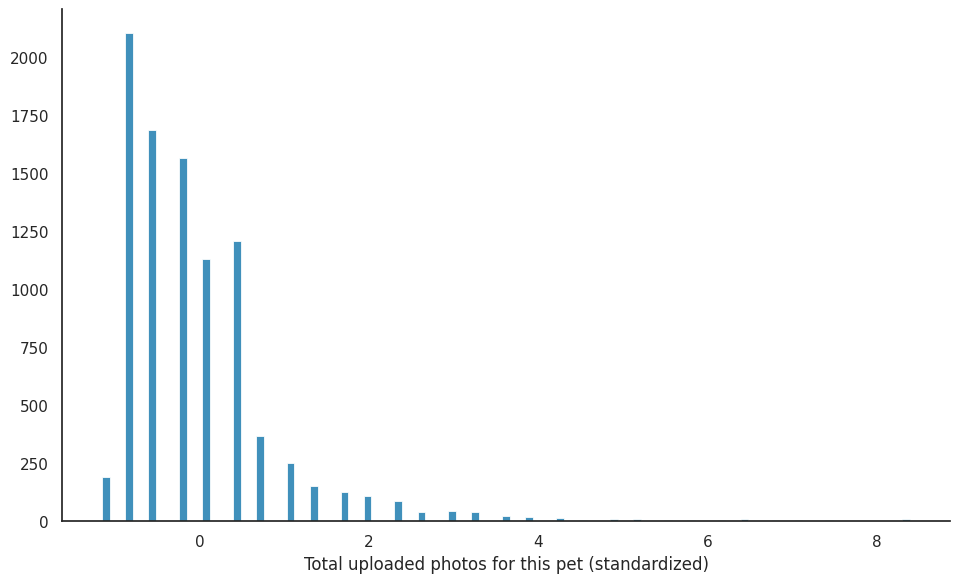

# 8. 모델링

## 8.1. statsmodels

### 8.1.1. PhotoAmt 이용

In [ ]:
y = y_train.values

X = X_train['PhotoAmt'].values
# 상수항으로 만들기
X = sm.add_constant(X)

X.shape, y.shape



```
((9222, 2), (9222,))
```



In [ ]:
y[:5]



```
array([1, 1, 1, 1, 1])
```



In [ ]:
X[:5]



```
array([[ 1.        , -0.82988776],
       [ 1.        ,  0.4413405 ],
       [ 1.        , -0.19427363],
       [ 1.        , -0.82988776],
       [ 1.        , -0.51208069]])
```



In [ ]:
m1_sm = sm.Logit(y, X)
res_sm = m1_sm.fit()
print(res_sm.summary())



```
Optimization terminated successfully.
         Current function value: 0.574120
         Iterations 6
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9222
Model:                          Logit   Df Residuals:                     9220
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Nov 2025   Pseudo R-squ.:                 0.01033
Time:                        11:54:41   Log-Likelihood:                -5294.5
converged:                       True   LL-Null:                       -5349.8
Covariance Type:            nonrobust   LLR p-value:                 7.486e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0316      0.024     42.963      0.000       0.984       1.079
x1             0.2886      0.030      9.684      0.000       0.230       0.347
==============================================================================
```



In [ ]:
print(f'Parameters: {[float(np.round(val, 2)) for val in res_sm.params]}')
print(f'Standard Errors: {[float(np.round(val, 2)) for val in res_sm.bse]}')
print(f'Predicted Values: {[float(np.round(val, 2)) for val in res_sm.predict()[:10]]}')



```
Parameters: [1.03, 0.29]
Standard Errors: [0.02, 0.03]
Predicted Values: [0.69, 0.76, 0.73, 0.69, 0.71, 0.88, 0.74, 0.69, 0.76, 0.76]
```



In [ ]:
pd.concat([pd.Series(res_sm.predict(X)), pd.Series(expit(res_sm.fittedvalues))], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

In [ ]:
res_sm_margeff = res_sm.get_margeff()
print(res_sm_margeff.summary())

    Marginal Effects란, 로지스틱 회귀의 비선형 성질을 고려하여, 특정 변수가 1 단위 증가할 때 예측 확률이 얼마나 변하는지를 나타내는 값
    다른 변수가 일정할 때 x1(사진 수)이 1 증가하면, 사건(즉, y=1일 확률)이 약 5.6%p 증가한다는 뜻 !!



```
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0558      0.006      9.807      0.000       0.045       0.067
==============================================================================
```



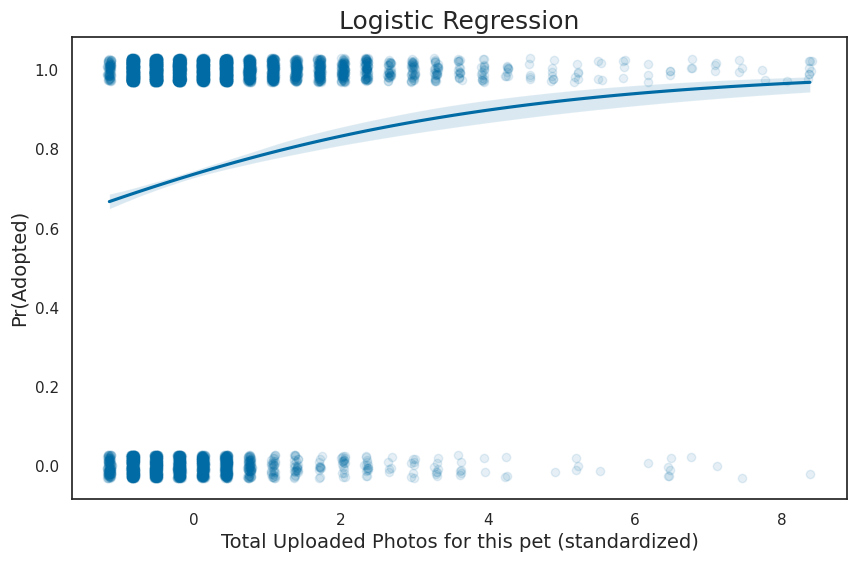

In [ ]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [ ]:
x = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind='cubic')
xnew = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_train['PhotoAmt'], rand_jitter(y_train), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total Uploaded Photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout()
plt.show()

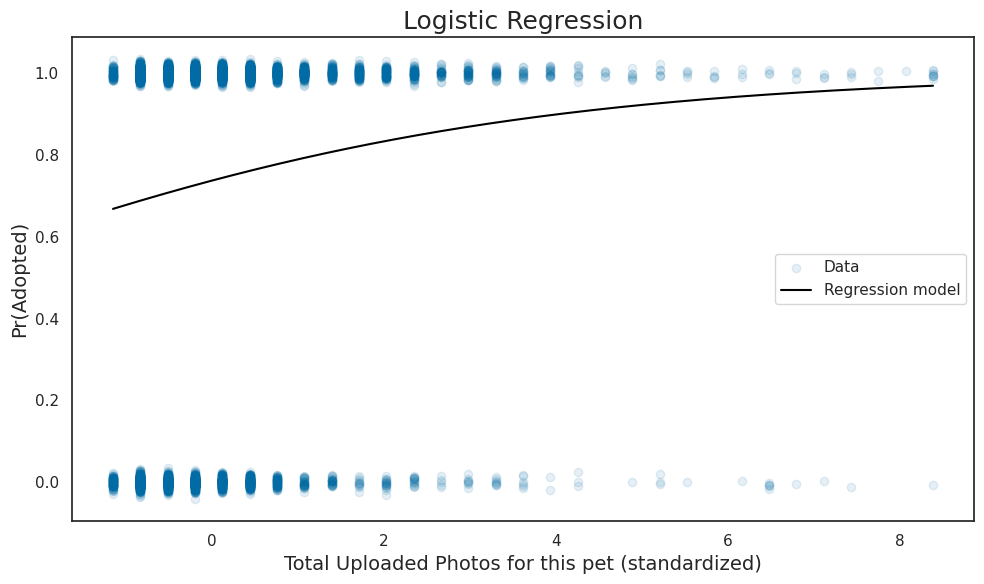

In [ ]:
X_tests = X_test['PhotoAmt'].values
X_tests = sm.add_constant(X_tests)
X_tests[:10]



```
array([[ 1.        , -0.82988776],
       [ 1.        ,  0.4413405 ],
       [ 1.        ,  0.75914757],
       [ 1.        , -0.82988776],
       [ 1.        , -0.82988776],
       [ 1.        , -0.19427363],
       [ 1.        ,  1.3947617 ],
       [ 1.        ,  0.4413405 ],
       [ 1.        , -0.51208069],
       [ 1.        , -0.82988776]])
```



In [ ]:
y_pred_probs = res_sm.predict(exog=X_tests)

y_pred_probs[:10]



```
array([0.68827565, 0.76113543, 0.77740815, 0.68827565, 0.68827565,
       0.72621288, 0.80753124, 0.76113543, 0.70760517, 0.68827565])
```



In [ ]:
y_preds = list(map(round, y_pred_probs))

y_preds[:10]



```
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
```



In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted', 'Adopted'])
disp.plot()
plt.show()

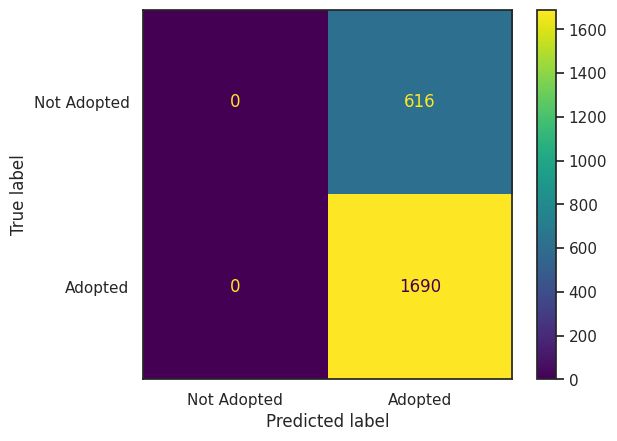

In [ ]:
print(classification_report(y_test, y_preds, target_names=['Not Adopted', 'Adopted']))

    recall이 100%가 나왔다는 것은 사실 말이 되지 않는 수치



```
              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       616
     Adopted       0.73      1.00      0.85      1690

    accuracy                           0.73      2306
   macro avg       0.37      0.50      0.42      2306
weighted avg       0.54      0.73      0.62      2306
```



In [ ]:
test_accuracy_sm = accuracy_score(y_test, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sm))



```
Test set (aka out-of-sample) Accuracy: 0.733
```



In [ ]:
test_precision_sm = precision_score(y_test, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sm))



```
Test set (aka out-of-sample) Precision: 0.733
```



In [ ]:
test_recall_sm = recall_score(y_test, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sm))



```
Test set (aka out-of-sample) Recall: 1.000
```



    PhotoAmt만 가지고서는 모델링이 제대로 되지 않음을 확인할 수 있다 !!

### 8.1.2. 설명 변수 이용

In [ ]:
X_train_multi = X_train[['DescriptionLength', 'AvgWordLength']]
X_train_multi = sm.add_constant(X_train_multi)

y_train_vals = y_train.values

multi_model = sm.Logit(y_train_vals, X_train_multi)
multi_res = multi_model.fit()

print(multi_res.summary())



```
         Current function value: 0.579214
         Iterations 5
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9222
Model:                          Logit   Df Residuals:                     9219
Method:                           MLE   Df Model:                            2
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                0.001550
Time:                        06:09:48   Log-Likelihood:                -5341.5
converged:                       True   LL-Null:                       -5349.8
Covariance Type:            nonrobust   LLR p-value:                 0.0002511
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0139      0.024     42.946      0.000       0.968       1.060
DescriptionLength     0.0998      0.027      3.725      0.000       0.047       0.152
AvgWordLength        -0.0261      0.023     -1.135      0.256      -0.071       0.019
```



    DescriptionLength가 표준화된 단위로 1 증가할 때, 입양될 로그 오즈가 0.0998만큼 증가한다.
    근데 내가 궁금한 것은? DescriptionLength가 1 증가할 때 입양 확률이 얼마나 변하는가이다.
    
    이를 위해서 한계 효과(Marginal Effects)를 게산하는 것 !!

In [ ]:
margeff = multi_res.get_margeff()
print(margeff.summary())



```
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DescriptionLength     0.0195      0.005      3.732      0.000       0.009       0.030
AvgWordLength        -0.0051      0.004     -1.135      0.256      -0.014       0.004
=====================================================================================
```





```
다른 변수가 일정할 때 x1(설명의 길이)이 1 증가하면, 입양될 확률(즉, y=1일 확률)이 약 2%p 증가한다 !!
```



In [ ]:
from scipy.special import expit

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'lines.linewidth': 2
})

X_photo = sm.add_constant(X_train['PhotoAmt'])
y = y_train.values
model_photo = sm.Logit(y, X_photo)
res_photo = model_photo.fit(disp=False)

x_range_photo = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 100)
X_sim_photo = sm.add_constant(x_range_photo)
p_photo = expit(res_photo.predict(X_sim_photo))
marginal_photo = res_photo.params['PhotoAmt'] * p_photo * (1 - p_photo)

X_desc = sm.add_constant(X_train[['DescriptionLength', 'AvgWordLength']])
model_desc = sm.Logit(y, X_desc)
res_desc = model_desc.fit(disp=False)

x_range_desc = np.linspace(X_train['DescriptionLength'].min(), X_train['DescriptionLength'].max(), 100)
avg_word_len = X_train['AvgWordLength'].mean()
X_sim_desc = pd.DataFrame({'const': 1, 'DescriptionLength': x_range_desc, 'AvgWordLength': avg_word_len})
p_desc = expit(res_desc.predict(X_sim_desc))
marginal_desc = res_desc.params['DescriptionLength'] * p_desc * (1 - p_desc)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# ---- Left: PhotoAmt ----
axes[0].plot(x_range_photo, marginal_photo, color='#1f77b4', linewidth=2.5)
axes[0].set_title('Marginal Effect of PhotoAmt')
axes[0].set_xlabel('Standardized PhotoAmt')
axes[0].set_ylabel('Marginal Effect (ΔP)')
axes[0].grid(alpha=0.25, linestyle='--')

axes[0].annotate('High initial impact (~6%)',
                 xy=(x_range_photo[5], marginal_photo[5]),
                 xytext=(x_range_photo[15], marginal_photo[5]),
                 arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'),
                 fontsize=11, color='black')

axes[0].annotate('Diminishing returns as photos increase',
                 xy=(x_range_photo[-10], marginal_photo[-10]),
                 xytext=(x_range_photo[40], marginal_photo[-10] - 0.002),
                 arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'),
                 fontsize=11, color='black')

# ---- Right: DescriptionLength ----
axes[1].plot(x_range_desc, marginal_desc, color='#ff7f0e', linewidth=2.5)
axes[1].set_title('Marginal Effect of DescriptionLength')
axes[1].set_xlabel('Standardized DescriptionLength')
axes[1].set_ylim(0.015, 0.025)  # y축 범위 조정
axes[1].grid(alpha=0.25, linestyle='--')

axes[1].annotate('Flat marginal effect (~2%)',
                 xy=(x_range_desc[40], marginal_desc[40]),
                 xytext=(x_range_desc[70], marginal_desc[40] + 0.002),
                 arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'),
                 fontsize=11, color='black')

# 전체 제목
fig.suptitle('Marginal Effect Comparison Across Separate Logistic Models', fontsize=16, y=1.03)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

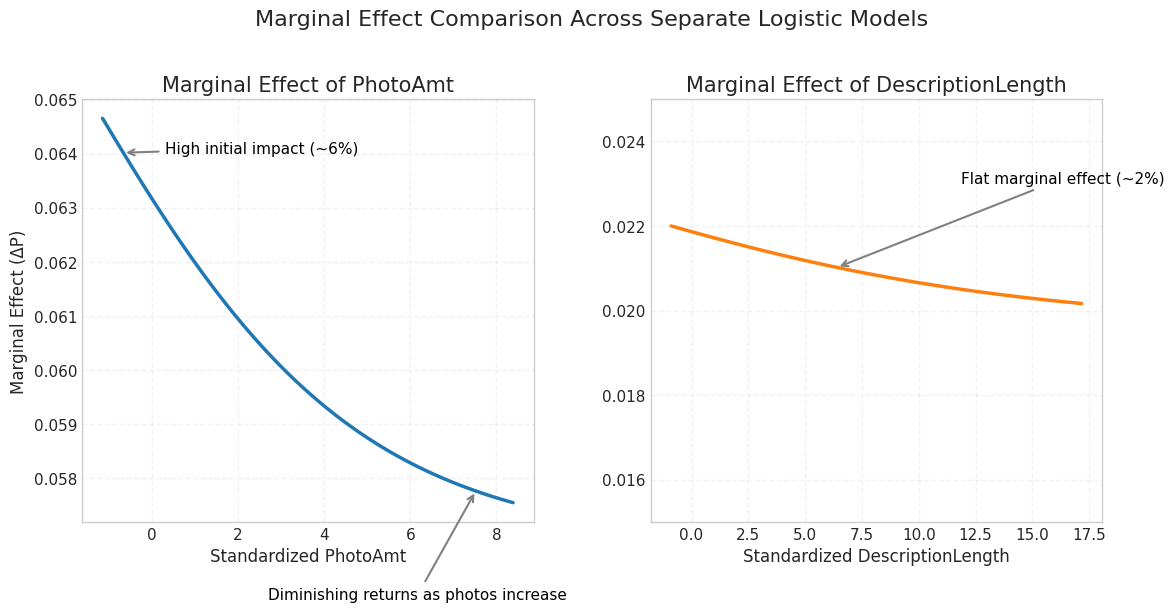

## 8.2. scikit-learn

### 8.2.1. LogisticRegression 모델 학습

In [ ]:
y = y_train.values

X = X_train['PhotoAmt'].values
X = sm.add_constant(X)

X.shape, y.shape

    ((9222, 2), (9222,))

In [ ]:
lr = LogisticRegression(penalty=None, fit_intercept=False)
res_sk = lr.fit(X, y)
res_sk

In [ ]:
coefs = [np.round(val, 4) for val in res_sk.coef_.flatten()]

ols_coefs = pd.DataFrame.from_dict(dict(zip(['Intercept', 'PhotoAmt'], coefs)), orient='index')
ols_coefs.columns = ['coef']

ols_coefs

|  | coef |
| :------------------ | :------------------------- |
| Intercept | 1.0315 |
| PhotoAmt | 0.2884 |

In [ ]:
x = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind='cubic')
xnew = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_train['PhotoAmt'], rand_jitter(y_train), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout()
plt.show()

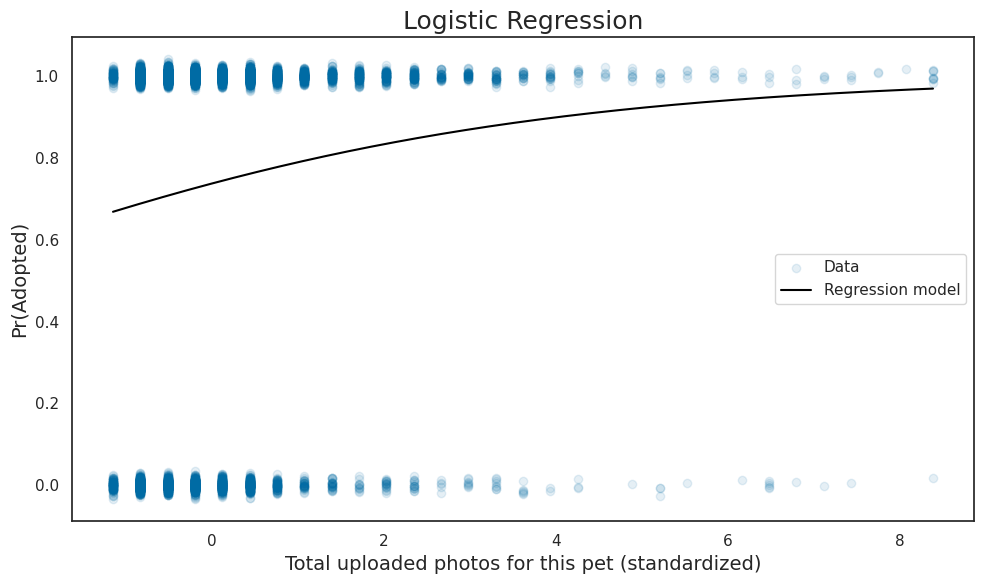

In [ ]:
X_tests = X_test['PhotoAmt'].values
X_tests = sm.add_constant(X_tests)

X_tests[:10]



```
array([[ 1.        , -0.82988776],
       [ 1.        ,  0.4413405 ],
       [ 1.        ,  0.75914757],
       [ 1.        , -0.82988776],
       [ 1.        , -0.82988776],
       [ 1.        , -0.19427363],
       [ 1.        ,  1.3947617 ],
       [ 1.        ,  0.4413405 ],
       [ 1.        , -0.51208069],
       [ 1.        , -0.82988776]])
```



In [ ]:
res_sk.classes_

    array([0, 1])

In [ ]:
y_pred_probs = res_sk.predict_proba(X_tests)
y_pred_probs[:10]



```
array([[0.31169678, 0.68830322],
       [0.23888257, 0.76111743],
       [0.22261882, 0.77738118],
       [0.31169678, 0.68830322],
       [0.31169678, 0.68830322],
       [0.27378419, 0.72621581],
       [0.19251066, 0.80748934],
       [0.23888257, 0.76111743],
       [0.29238001, 0.70761999],
       [0.31169678, 0.68830322]])
```



In [ ]:
y_preds = res_sk.predict(X_tests)
y_preds[:10]

    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted', 'Adopted'])
disp.plot()
plt.show()

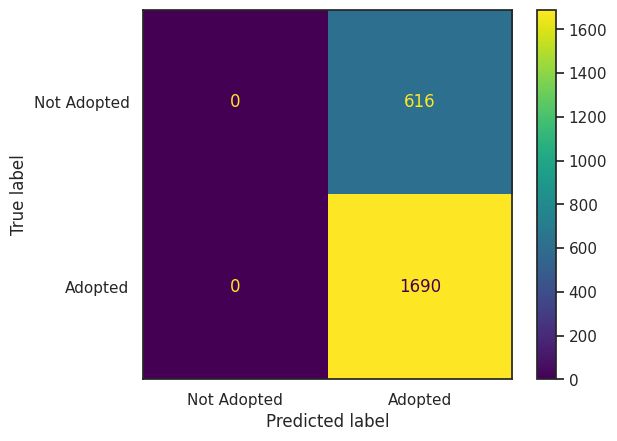

In [ ]:
print(classification_report(y_test, y_preds, target_names=['Not Adopted', 'Adopted']))



```
              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       616
     Adopted       0.73      1.00      0.85      1690

    accuracy                           0.73      2306
   macro avg       0.37      0.50      0.42      2306
weighted avg       0.54      0.73      0.62      2306
```



In [ ]:
test_accuracy_sk = accuracy_score(y_test, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sk))



```
Test set (aka out-of-sample) Accuracy: 0.733
```



In [ ]:
test_precision_sk = precision_score(y_test, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sk))



```
Test set (aka out-of-sample) Precision: 0.733
```



In [ ]:
test_recall_sk = recall_score(y_test, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sk))



```
Test set (aka out-of-sample) Recall: 1.000
```



    statsmodels와 동일한 결과가 나옴을 확인할 수 있다 !

### 8.2.2. RandomForestClassifier로 변수 중요도도 살펴보자

In [ ]:
from sklearn.ensemble import RandomForestClassifier

all_features = list(features.columns)

rf_model = RandomForestClassifier(n_estimators=100, random_state=1234, n_jobs=-1)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

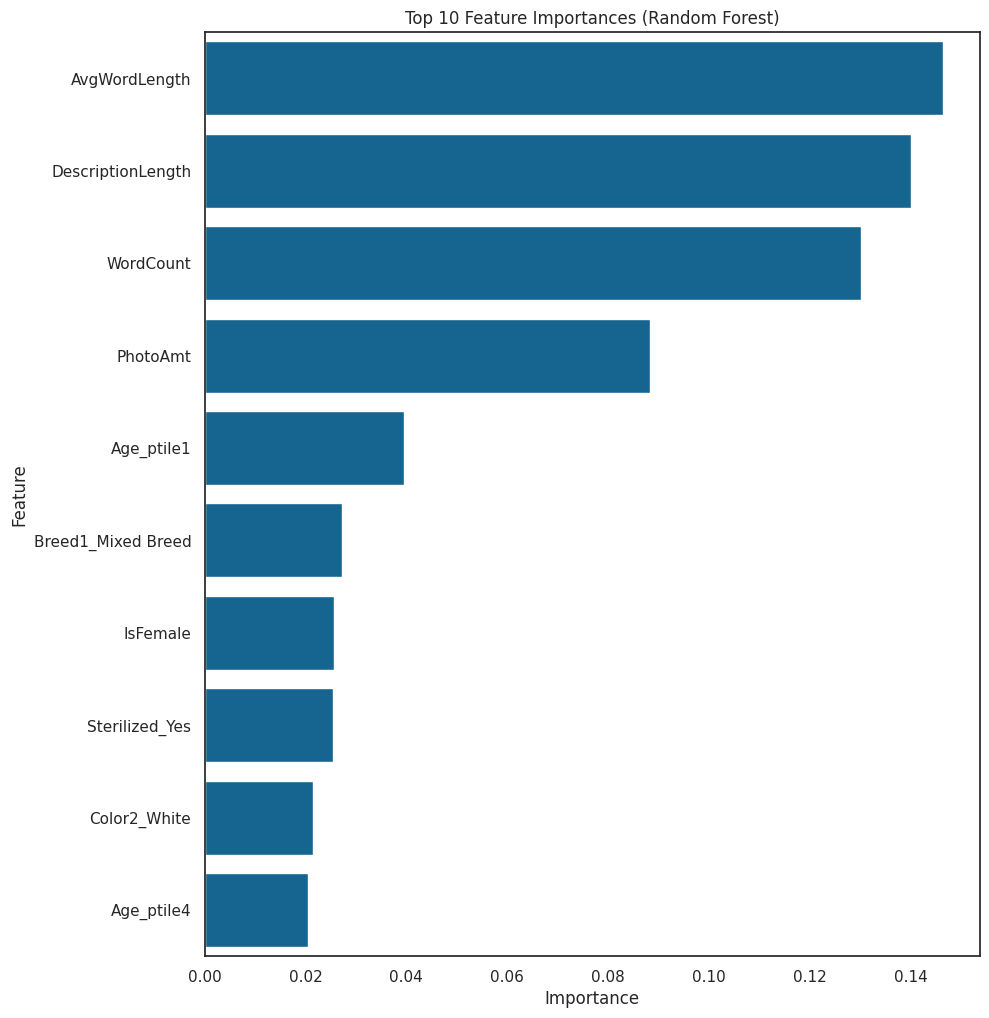

## 8.3. tensorflow

In [ ]:
df = pd.read_csv('Data/petfinder-mini.csv')

# 파생 변수를 만들기 위해 설명란이 결측인 데이터 행은 날리기
df = df.dropna(subset=['Description'])

# Binary 문제로 변형하기 위해, AdoptionSpeed가 4면, 입양 안 된 것, 그 외에는 된 것으로 변경
df['target'] = np.where(df['AdoptionSpeed'] == 4, 0, 1)

# 설명으로도 무언가를 할 수 있을 듯하여 일단 파생 변수들 만들어보기
df['DescriptionLength'] = df['Description'].str.len()
df['WordCount'] = df['Description'].str.split().apply(len)
df['AvgWordLength'] = df['DescriptionLength'] / df['WordCount']

df = df.drop(columns=['AdoptionSpeed', 'Description'])

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
print(len(train), 'Training examples')
print(len(val), 'Validation examples')
print(len(test), 'Test examples')



```
9222 Training examples
1153 Validation examples
1153 Test examples
```



In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    '''
    tensorflow 사용을 위해 데이터프레임을 데이터셋으로 변환해주는 함수
    '''
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value.values[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [ ]:
def get_normalization_layer(name, dataset):
    '''
    Layer 자체를 Normalization해주는 함수
    '''
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    '''
    위에서 했던 카테고리 인코딩 작업을 진행해주는 함수
    '''
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    return lambda feature: encoder(index(feature))

In [ ]:
batch_size = 256

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
all_inputs = []
encoded_features = []

for header in ['PhotoAmt', 'Fee', 'DescriptionLength', 'WordCount', 'AvgWordLength']:
    numeric_col = tf.keras.Input(shape=(1, ), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [ ]:
age_col = tf.keras.Input(shape=(1, ), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)

encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [ ]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1, ), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                 dataset=train_ds,
                                                 dtype='string',
                                                 max_tokens=5)

    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Use 'rankdir=LR' to make the graph horizantal
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

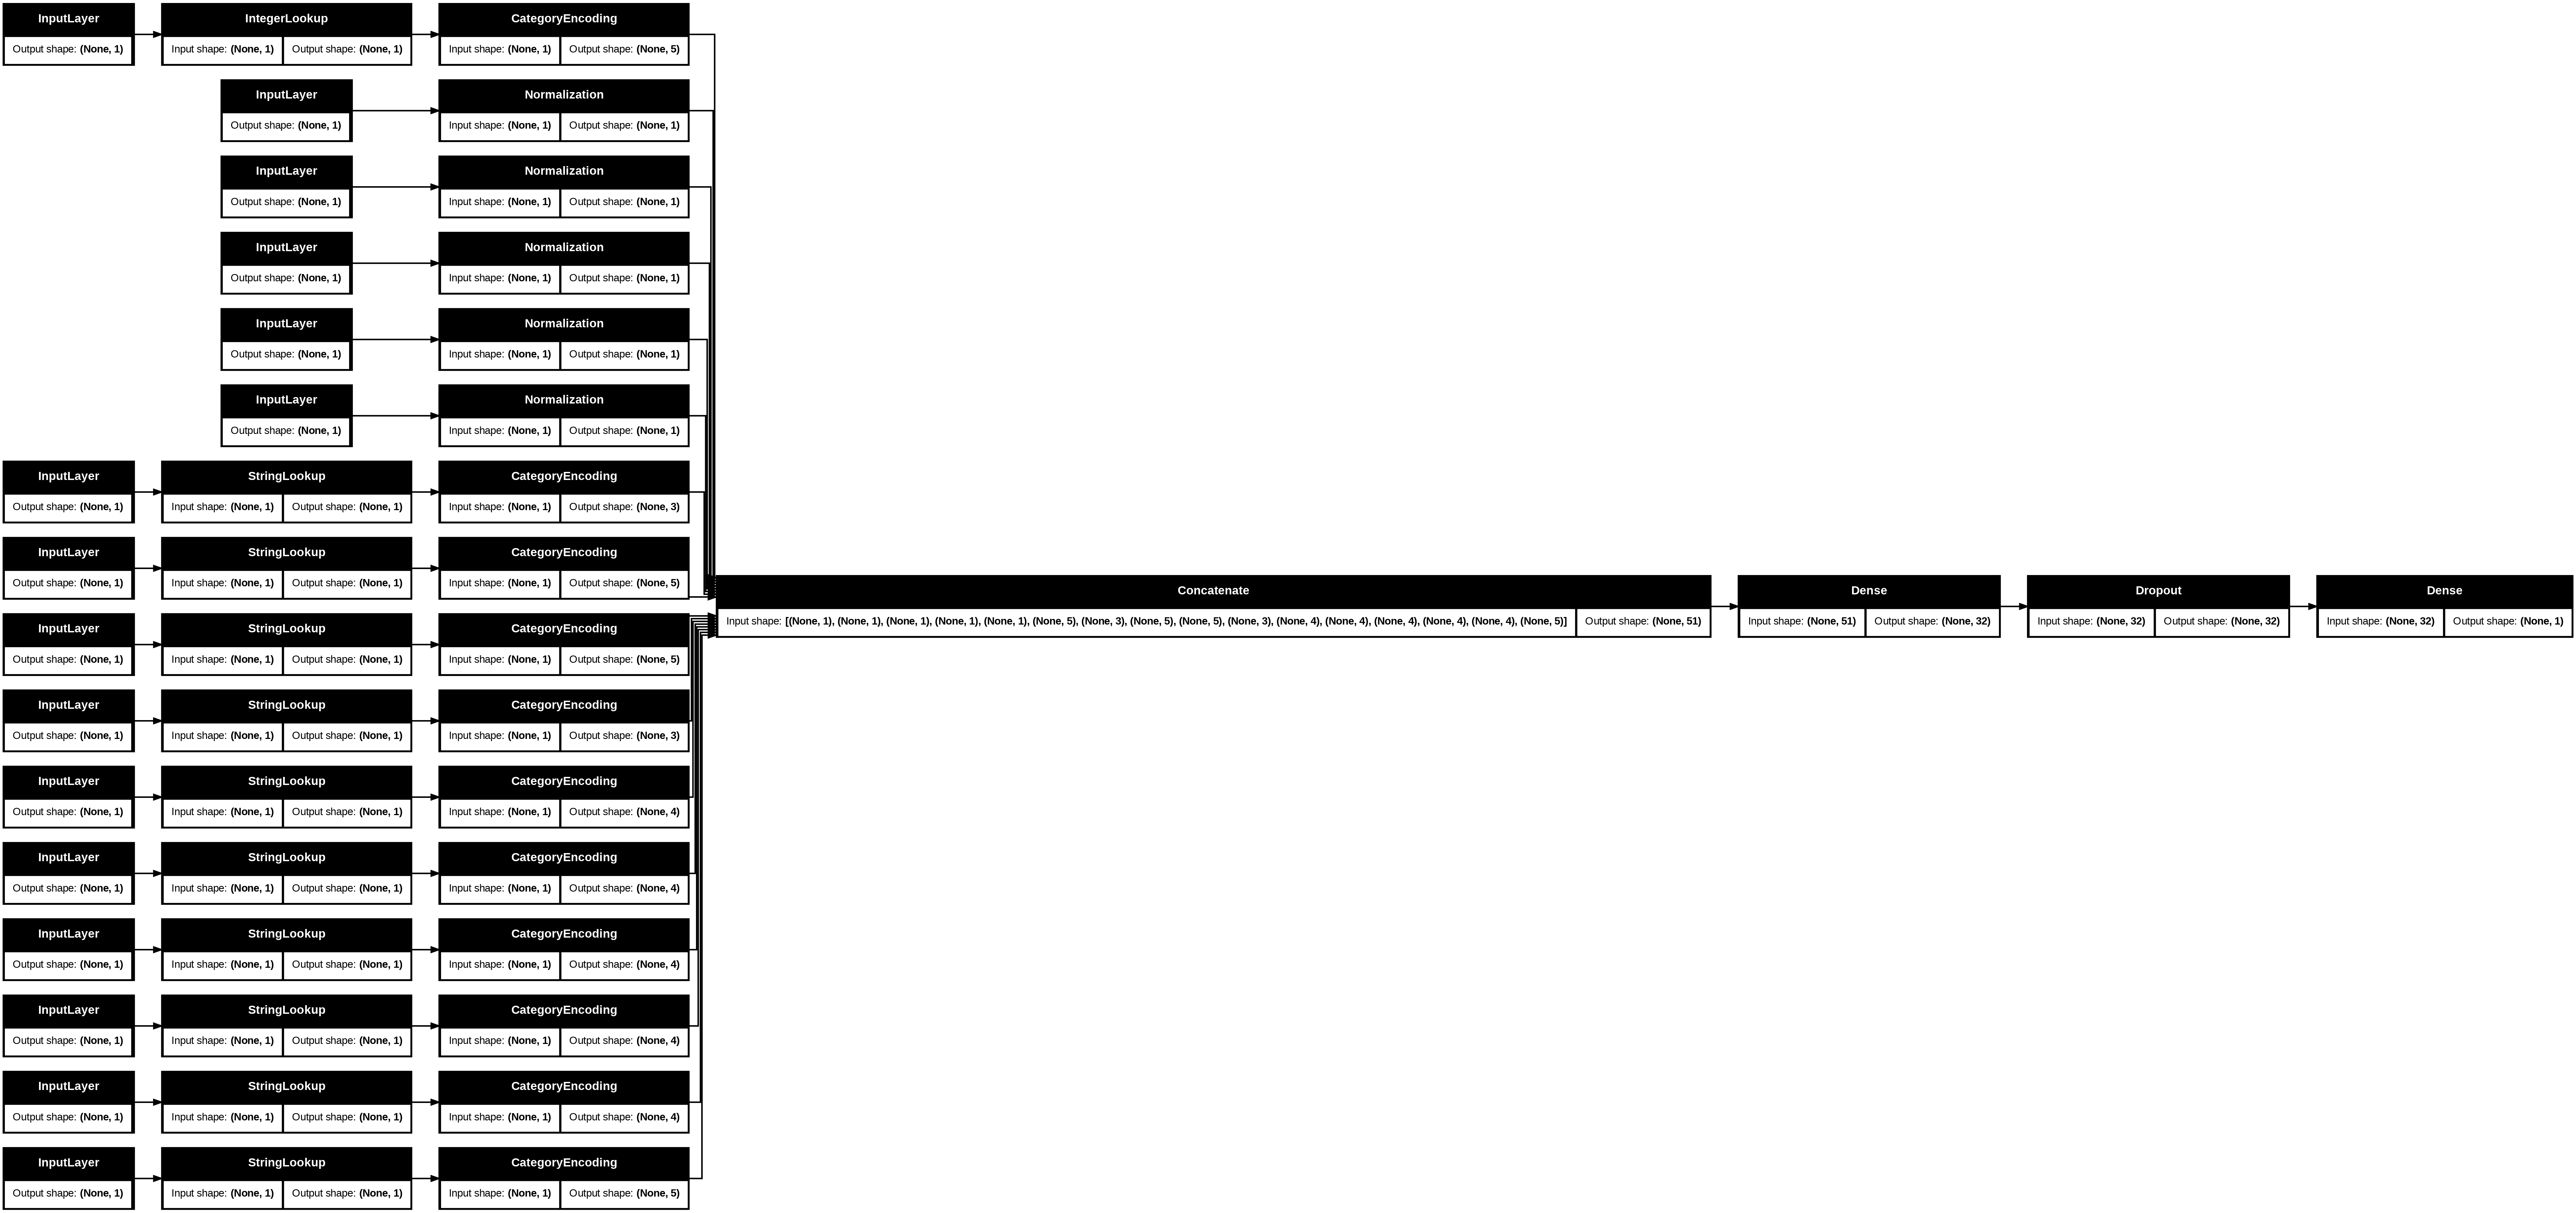

In [ ]:
baseline_history = model.fit(train_ds, epochs=10, validation_data=val_ds)
baseline_history

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Accuracy', np.round(accuracy, 3))



```
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7202 - loss: 0.5252
Accuracy 0.717
```



In [ ]:
test['target'].values



```
array([1, 1, 1, ..., 1, 1, 1])
```



In [ ]:
model.predict(test_ds).flatten()



```
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step
array([ 0.6483113 , -0.15896416,  0.18506056, ...,  0.8348784 ,
        0.551763  ,  0.03077281], dtype=float32)
```



In [ ]:
cm = confusion_matrix((model.predict(test_ds) > 0.5).astype('int32').flatten(), test['target'].values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted', 'Adopted'])
disp.plot()
plt.show()

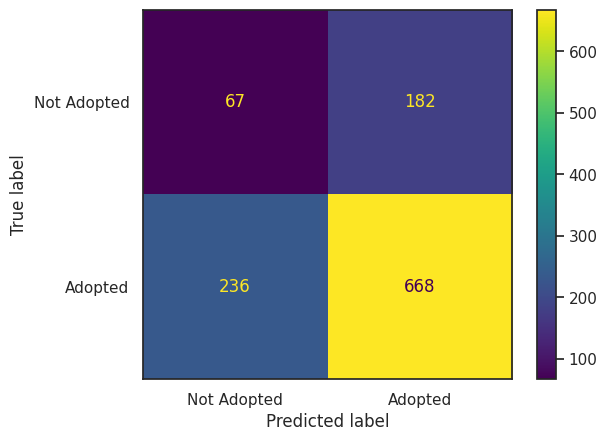

In [ ]:
precision = precision_score((model.predict(test_ds) > 0.5).astype('int32').flatten(), test['target'].values)
recall = recall_score((model.predict(test_ds) > 0.5).astype('int32').flatten(), test['target'].values)
print(classification_report((model.predict(test_ds) > 0.5).astype('int32').flatten(), test['target'].values, target_names=['Not Adopted', 'Adopted']))



```
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

 Not Adopted       0.22      0.27      0.24       249
     Adopted       0.79      0.74      0.76       904

    accuracy                           0.64      1153
   macro avg       0.50      0.50      0.50      1153
weighted avg       0.66      0.64      0.65      1153
```



In [ ]:
model.save('my_pet_classifier.keras')
reloaded_model = tf.keras.models.load_model('my_pet_classifier.keras')

# 9. 모델 이용 및 비교

## 9.1. 시뮬레이션

In [ ]:
sample = {
    'Type': 'Dog',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
    'AvgWordLength': 20,
    'WordCount': 0,
    'DescriptionLength': 0
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
reloaded_model = tf.keras.models.load_model('my_pet_classifier.keras')
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    'This particular pet had a %.1f percent probability '
    'of getting adopted.' % (100 * prob)
)



```
Default 확률
This particular pet had a 79.0 percent probability of getting adopted.

사진 장 수를 2 -> 50장으로 늘렸을 때,
This particular pet had a 99.4 percent probability of getting adopted.

나이를 3 -> 1로 줄였을 때,
This particular pet had a 85.6 percent probability of getting adopted.

AvgWordLength를 0 -> 20으로 늘렸을 때,
This particular pet had a 80.2 percent probability of getting adopted.
```



## 9.2. 모델 비교

In [ ]:
pd.DataFrame([[test_accuracy_sm, test_precision_sm, test_recall_sm],
              [test_accuracy_sk, test_precision_sk, test_recall_sk],
              [accuracy, precision, recall]],
             index=['statsmodels', 'scikit-learn', 'tensorflow'],
             columns=['Accuracy', 'Precision', 'Recall']).round(2)

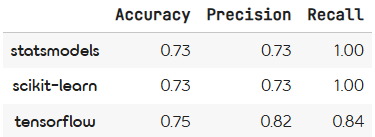

# 10. 결론

---


```
▸ 자기 회사에 녹아들어야 데이터에 녹아들 수 있다.

어느 회사에 들어가든지 간에 그 회사에 녹아들어야 한다.
예를 들어 패션 회사라면, 이런 저런 옷도 많이 사봐야 한다.

그리고 일하는 분야에 대한 질문도 다양한 사람들에게 많이 해봐야 한다.

▸ 문자열 데이터는 어떻게 처리할까?

1. 우리가 접하는 대부분의 데이터는 사람들이 실제로 기록하거나, 사람들의 정보를 모아둔 데이터이기 때문에 문자열 형태의 데이터가 가장 많다.
2. 문자열 데이터의 경우에는 크게 1) 범주화, 2) 다양한 임베딩 방법으로 처리할 수 있다.
3. 모델링에는 다양한 목적이 있음을 인식해야 한다. 단순히 0, 1을 예측하는 경우도 있고, 다중 Class를 예측하는 문제도 있다.
4. 최근 들어 이런 것보다 잘 맞추면 잘 맞추는 이유, 핸들링할 수 있는 변수를 핸들링했을 때 어떻게 바뀌는지에 대해 더 궁금해 하는 경우가 많다.
5. DL이 만능은 아니다.
- 하지만, 가진 데이터의 분포가 충분히 학습 가능해보이지만, 학습되지 않을 때,
- 알 수 없는 특성의 학습이 필요하다고 판단될 때는 시도해볼 만하다.
```

